# RBF approximation for non-Gaussian delay propagation in VLSI
### Dmytro Mishagli

This Notebook contains the code to reproduce the results shown in the paper 'Radial Basis Functions Based Algorithms for non-Gaussian Delay Propagation in Very Large Circuits' by D. Mishagli and E. Blokhina.

In [1]:
import numpy as np
import scipy.special as sp
from scipy.optimize import curve_fit
import random
import matplotlib.pyplot as plt
%matplotlib inline
   
# Get another fonts
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist]);

## Define All Functions

### RBF approach
Define a Radial Basis Function:

In [2]:
def rbf(x,loc,shape):
    '''
    Radial Basis function.
    
    Parameters:
    loc   -- float, defines a location of an RBF
    shape -- float, defines a shape (>0)
    '''
    return np.exp( -(x-loc)**2/(2*shape**2) )

Based on this RBF, define a Gaussian comb and corresponding expressions for the mean value and variance:

In [3]:
'''
The functions below have the following Parameters:
weights -- list of floats, weights for kernels (all weights >0)
locs    -- list of floats, locations of kernels in a comb
shape   -- float, a shape parameter (>0)
'''

def gauss_comb(x, weights, locs, shape):
    '''
    The sum of equally separated weighted RBFs, a Gaussian comb.
    '''
    result = 0
    for w,b in zip(weights,locs):
        result += w * rbf(x,b,shape)
        
    return result

def comb_mean(weights, locs):
    '''
    A mean value in the comb representation.
    Note that first the corresponding comb should be constructed that has a meaning of a PDF.
    '''
    result = 0
    for w,b in zip(weights,locs):
        result += w * b * shape
        
    return np.sqrt(2*np.pi) * result

def comb_var(weights, locs, shape):
    '''
    A variance in the comb representation.
    Note that first the corresponding comb should be constructed that has a meaning of a PDF.
    '''
    result = 0
    for w,b in zip(weights,locs):
        result += w*shape * (b**2 + shape**2)
    
    return np.sqrt(2*np.pi) * result - comb_mean(weights, locs)**2

### Analytical solution for the total gate delay

Derivation of these formulas is to be published.

A total gate delay is determined by (i) input signals' delays and (ii) gate's operation time. For the case of two input signals and all delays normally distributed, the probability density function $\mathfrak f(x)$ of the total gate delay reads

In [4]:
# Gaussian kernel funcion
gkernel = lambda x: np.exp( - x**2 / 2 )
# Gaussian cdf
Phi = lambda x: 0.5 * ( 1 + sp.erf( x/np.sqrt(2) ) )

def gate_pdf (x, input1, input2, gate, rho):
    '''
    The probability density function of the total gate delay.
    
    Parameters:

    input1, input2 -- list, parameters that determine inputs' delays in the following format:
                      [1/(np.sqrt(2*np.pi)*std), mean value, std]
    gate           -- list, parameters that determine gate's operation time in the following format:
                      [1/(np.sqrt(2*np.pi)*std), mean value, std]
    rho            -- float (-1 < rho < 1), a correlation coefficient between inputs 
    '''
    mu0 = gate[1]
    mu1 = input1[1]
    mu2 = input2[1]
    means = [ mu0,mu1,mu2 ]
    
    s0 = gate[2]
    s1 = input1[2]
    s2 = input2[2]
    var = [ s0,s1,s2 ]
    
    a = [ gate[0], input1[0], input2[0] ]
    C = 2*np.pi * a[0]*a[1]*a[2] * s0*var[1]*var[2]
    
    sigma = lambda i: np.sqrt( s0**2 + var[int(i)]**2 )
    kappa = lambda i,j: s0*var[int(i)] / (var[int(j)]*sigma(i)) 
    
    fun = lambda i: gkernel( (x - mu0 - means[int(i)])/sigma(int(i)) )/sigma(int(i))
    
    coef = lambda i,j: 1 / np.sqrt( (1-rho**2)/( 1-rho*var[int(j)]/var[int(i)] )**2 + kappa(i,j)**2 )
    arg1 = lambda i,j: ( var[int(i)]**2 * (x-mu0) + s0**2*means[int(i)] )/(s0**2 + var[int(i)]**2)/var[int(j)] * np.sign( 1-rho*var[int(j)]/var[int(i)] )
    arg2 = lambda i,j: - ( var[int(i)]*means[int(j)]-rho*var[int(j)]*means[int(i)] ) / ( var[int(j)]*np.abs( var[int(i)]-rho*var[int(j)] ) )
    
    return  C * ( fun(1)*Phi( coef(1,2)*(arg1(1,2) + arg2(1,2)) ) + fun(2)*Phi( coef(2,1)*(arg1(2,1) + arg2(2,1)) ) )

The mean and variance of a gate delay:

In [5]:
# All parameters are the same as above.

def gate_mean (input1, input2, gate, rho):
    '''
    The first moment, mean value of the total gate delay.
    '''
    mu0 = gate[1]
    mu1 = input1[1]
    mu2 = input2[1]
    means = [ mu0,mu1,mu2 ]
    
    s0 = gate[2]
    s1 = input1[2]
    s2 = input2[2]
    var = [ s0,s1,s2 ]
    
    a = [ gate[0], input1[0], input2[0] ]
    C = 2*np.pi * a[0]*a[1]*a[2] * s0*var[1]*var[2]
    
    sigma = lambda i: np.sqrt( s0**2 + var[int(i)]**2 )
    kappa = lambda i,j: (var[int(i)] - rho*var[int(j)])/np.sqrt(1-rho**2) * s0 / (var[int(j)]*sigma(i))  
    
    coef = lambda i,j: np.sqrt( 1 + kappa(i,j)**2 * (var[int(i)]**2/s0**2 + 1) )
    arg  = lambda i,j: 1/np.sqrt(1-rho**2) * (means[int(i)]-means[int(j)]) / ( var[int(j)]*coef(i,j) )
    body = lambda i,j: np.sqrt(2*np.pi)*(mu0+means[int(i)]) * Phi(arg(i,j)) +  var[int(i)]*sigma(i)/s0 * kappa(i,j)/coef(i,j) * np.exp( -0.5*arg(i,j)**2 )
    
    return C * ( body(1,2) + body(2,1) )

def gateMoment2 (input1, input2, gate, rho):
    '''
    The second moment.
    '''
    mu0 = gate[1]
    mu1 = input1[1]
    mu2 = input2[1]
    means = [ mu0,mu1,mu2 ]
    
    s0 = gate[2]
    s1 = input1[2]
    s2 = input2[2]
    var = [ s0,s1,s2 ]
    
    a = [ gate[0], input1[0], input2[0] ]
    C = 2*np.pi * a[0]*a[1]*a[2] * s0*var[1]*var[2]
    
    sigma = lambda i: np.sqrt( s0**2 + var[int(i)]**2 )
    kappa = lambda i,j: (var[int(i)] - rho*var[int(j)])/np.sqrt(1-rho**2) * s0 / (var[int(j)]*sigma(i)) 
    varkappa = lambda i,j: np.sqrt( 1 + kappa(i,j)**2 * (1 + var[int(i)]**2 / s0**2) )
    
    arg1 = lambda i,j: kappa(i,j) * sigma(i)*means[int(i)]/(var[int(i)]*s0)
    arg2 = lambda i,j: means[int(j)]/var[int(j)] * ( 1 - rho*var[int(j)]*means[int(i)]/(var[int(i)]*means[int(j)]) ) / np.sqrt( 1 - rho**2 )
    y = lambda i,j: arg1(i,j) - arg2(i,j)
    
    coef1 = lambda i,j: np.sqrt(2*np.pi)*( (mu0+means[int(i)])**2 + sigma(i)**2 )
    coef2 = lambda i,j: 2*var[int(i)]*sigma(i)**2/s0 * kappa(i,j)/varkappa(i,j) * ( (mu0+means[int(i)])/sigma(i) - 0.5*var[int(i)]/s0 * kappa(i,j)/varkappa(i,j)**2 * y(i,j))
    body  = lambda i,j:  coef1(i,j) * Phi(y(i,j)/varkappa(i,j)) +  coef2(i,j) * np.exp( -0.5*y(i,j)**2/varkappa(i,j)**2 )
    
    return C * ( body(1,2) + body(2,1) )


def gate_var (input1, input2, gate, rho):
    '''
    The variance of the total gate delay.
    '''
    return gateMoment2 (input1, input2, gate, rho) - gate_mean(input1, input2, gate, rho)**2

When the inputs are given by Gaussian combs, the pdf, mean and variance of the total gate delay are determined as follows:

In [6]:
'''
Parameters:
input1, input2   -- double array of floats, parameters that determine inputs' delays in a comb representation.
                    input1[0], input2[0] contain weights for kernels
                    input1[1], input2[1] contain locations of kernels

gate, rho, shape --  the same as above.
'''

def decomposed_gate_pdf(x, input1, input2, gate, rho, shape):
    """
    The total gate delay's pdf if inputs are given via Gaussian combs.
    """
    # unpack inputs
    weights_1, locs_1 = input1
    weights_2, locs_2 = input2
    result = 0
    for w1,m1 in zip(weights_1,locs_1):
        for w2,m2 in zip(weights_2,locs_2):
            result += gate_pdf(x, [w1, m1, shape], [w2, m2, shape], gate, rho )

    return result

def decomposed_gate_mean(input1, input2, gate, rho, shape):
    """
    The mean value of the total gate deay if inputs are given via Gaussian combs.
    """
    # unpack inputs
    weights_1, means_1 = input1
    weights_2, means_2 = input2
    result = 0
    for w1,m1 in zip(weights_1,means_1):
        for w2,m2 in zip(weights_2,means_2):
            result += gate_mean([w1, m1, shape], [w2, m2, shape], gate, rho )

    return result

def decomposed_gate_var(input1, input2, gate, rho, shape):
    """
    The variance of the total gate delay if inputs are given via Gaussian combs.
    """
    # unpack inputs
    weights_1, means_1 = input1
    weights_2, means_2 = input2
    result = 0
    for w1,m1 in zip(weights_1,means_1):
        for w2,m2 in zip(weights_2,means_2):
            result += gateMoment2([w1, m1, shape], [w2, m2, shape], gate, rho )

    return result - decomposed_gate_mean(input1, input2, gate, rho, shape)**2

## Algorithms

The methodology is tested on a model circuit shown below.

<img src="logic_gates_chain_(lncs).png" alt="logic_gates_chain_(lncs)" width="450"/>

For $n$ logic gates there are $n+1$ inputs in the circuit. Thus, it is required first to simulate the inputs and then traverse a delay through all the gates.

### Gaussian Comb Algorithm

In [7]:
def get_comb(actual_mean, actual_std, xdata, ydata, n_rbf_func, shape):
    """
    The function returns weights w_i and locations b_i of kernels for a Gaussian comb.
    
    Parameters:
    actual_mean  -- float, a mean value for a PDF to fit
    actual_std   -- float, an std for a PDF to fit
    xdata, ydata -- arrays of floats, values of a function to fit and corresponding x-values
                    (in the paper these are the bandwidth $\delta y$)
    n_rbf_func   -- int, number of RBFs in a comb
    shape        -- float, shaping parameter (>0)
    """
    # locations of kernels, array with b_i equally separated
    locs = np.linspace(actual_mean - 4*actual_std, actual_mean + 4*actual_std, n_rbf_func)
    # guess [1,1,...,1]
    guess = [1 for _ in range(n_rbf_func)]
    # bounds (all weights > 0)
    bnds = ([0 for _ in range(n_rbf_func)],np.inf)
    # Gaussian mixture (f_rbf)
    mixture = lambda x,*p: gauss_comb(x,p,locs,shape)
    # find the weights for the mixture
    popt, pcov = curve_fit(mixture, xdata, ydata, guess, bounds=bnds)
    
    # return weighted Gaussian comb (weights and locs)
    return popt, locs

def preprocess_inputs(input_means, input_stds, n_rbf_func, shape, distribution):
    '''
    The function represents all inputs via Gaussian combs. Returns a list of lists.
    Each sublist contains comb's weights and locs for the corresponding input.
    
    Parameters:
    input_means  -- list of floats, inputs' mean values of delays
    input_stds   -- list of floats, inputs' standard deviations of delays
    n_rbf_func   -- int, number of RBFs in a comb
    shape        -- float, shaping parameter (>0)
    distribution -- str, defines a distribution to draw samples from; can take one of two values:
                    'Normal' or 'LogNormal'
    '''
    
    # Gaussian normalisation coefficient
    a = lambda x: 1/(np.sqrt(2*np.pi)*x)
    
    # create an empty list to store the combs's weights and locs
    result = [ ]
    
    # if input nodes are described by Gaussian distributions
    if distribution == 'Normal':
        for i in range(len(input_means)):
            # get the data for input nodes
            xdata = np.linspace(input_means[i]-6*input_stds[i], input_means[i]+6*input_stds[i], 75)
            ydata = a(input_stds[i])*rbf(xdata,input_means[i],input_stds[i])
            
            # get a Gaussian comb and append its weights and locs to the list
            result.append(get_comb(input_means[i], input_stds[i], xdata, ydata, n_rbf_func, shape))
            
    # if input nodes are described by LogNormal distributions
    if distribution == 'LogNormal':
        for i in range(len(input_means)):
            sigma = np.sqrt( np.log( input_stds[i]**2/(input_means[i]**2) + 1 ) )
            mu = np.log(input_means[i]) - sigma**2/2
            # define a PDF of the lognorm dostribution
            lognorm_pdf = lambda x: (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))/ (x * sigma * np.sqrt(2 * np.pi)))
            # get the data for input nodes
            xdata = np.arange(0.1, input_means[i]+6*input_stds[i], 0.01)
            ydata = lognorm_pdf(xdata)
        
            # get a Gaussian comb and append its weights and locs to the list
            result.append(get_comb(input_means[i], input_stds[i], xdata, ydata, n_rbf_func, shape))
    
    return result


def get_convolution(input1, input2, gate, n_rbf_func, shape):
    '''
    Performs the convolution of two PDFs given by Gaussian combs (distributions of inputs' delays)
    with a Gaussian PDF (distribution of gate's operation time).
    Returns a PDF of the total gate delay in a Gaussian comb form.
    
    Parameters:
    input1, input2 -- arrays of floats, two inputs given by Gaussian combs
    gate           -- list of floats, determines gate's operation time in the following format:
                      [mean value, std];
    n_rbf_func     -- int, number of RBFs in a comb
    shape          -- float, shaping parameter (>0)
    '''
    # assume there are no correlations
    rho = 0
    # mean and std of the gate operation time
    m0, s0 = gate
    gate = [ 1/( np.sqrt(2*np.pi)*s0 ), m0, s0 ]

    # get mean and std of the total gate delay
    node_mean = decomposed_gate_mean(input1, input2, gate, rho, shape)
    node_std = np.sqrt(decomposed_gate_var(input1, input2, gate, rho, shape))
    # get data for the total gate delay's PDF
    xdata = np.arange(node_mean-5*node_std, node_mean+5*node_std, 0.1)
    ydata = decomposed_gate_pdf(xdata,input1,input2,gate,rho,shape)
    # get a Gaussian comb for the PDF
    result = get_comb(node_mean, node_std, xdata, ydata, n_rbf_func, shape)
    
    return result

### Monte Carlo

In [8]:
def MonteCarlo_inputs(input_means, input_stds, n_samples, distribution):
    '''
    Generates random samples for all the inputs. Returns list of lists with random samples.
    Each sublist contains samples for the corresponding input.
    
    Parameters:
    input_means  -- list of floats, inputs' mean values of delays
    input_stds   -- list of floats, inputs' standard deviations of delays
    n_samples    -- int, number of samples used for each simulation
    distribution -- str, defines a distribution to draw samples from; can take one of two values:
                    'Normal' or 'LogNormal'
    '''
    
    # create an empty list of lists to store the simulation data
    montecarlo = [[] for _ in range(len(input_means)) ]
    
    if distribution == 'Normal':
        # get the data for input nodes
        for i in range(len(input_means)):
            montecarlo[i] = np.random.normal(input_means[i], input_stds[i], n_samples)
            
    if distribution == 'LogNormal':
        # get the data for input nodes
        for i in range(len(input_means)):
            # get corresponding mu and sigma for the logrnomal pdf
            sigma = np.sqrt( np.log( input_stds[i]**2/(input_means[i]**2) + 1 ) )
            mu = np.log(input_means[i]) - sigma**2/2
            # generate lognormal samples
            montecarlo[i] = np.random.lognormal(mu, sigma, n_samples)
            
    return montecarlo

def MonteCarlo_nodes(input1, input2, gate, n_samples):
    '''
    Performs simuation of a logic gate operation and returns samples for the total gate delay.
    
    Parameters:
    input1, input2 -- arrays of floats, simulation samples for two inputs
    gate           -- list of floats, determines gate's operation time in the following format:
                      [mean value, std];
                      gate's operation time is assumed to have a Gaussian distribution
    n_samples      -- int, number of samples used
    '''
    m0 = gate[0]
    s0 = gate[1]
    
    # gate operation time is assumed to have Gaussian distribution
    montecarlo = np.maximum(input1,input2) + np.random.normal(m0, s0, n_samples)
    
    return montecarlo

## Simulations

In [9]:
# it is used 20 nodes in the simulations
number_of_nodes = 20

# fix the random seed for reproducibility 
random.seed(1235) # comment this line to get different results

# list with inputs' mean values
input_means = [ random.randint(20,70)/10 for _ in range(number_of_nodes+1) ]
# list with inputs' stds
input_stds = [ random.randint(20,130)/100 for _ in range(number_of_nodes+1) ]
print('input means:\n',input_means)
print('\ninput stds:\n',input_stds)

input means:
 [6.4, 4.7, 5.4, 5.7, 5.0, 4.5, 2.9, 6.5, 4.2, 6.6, 6.1, 7.0, 4.7, 3.3, 5.8, 2.6, 4.6, 3.6, 4.8, 4.2, 5.8]

input stds:
 [0.79, 1.04, 0.67, 1.17, 0.24, 1.3, 0.62, 1.21, 1.12, 1.17, 0.46, 1.01, 0.48, 1.08, 0.7, 0.22, 0.23, 1.26, 0.88, 0.87, 0.88]


In [10]:
# gate's operation time is fixed
gate = [1, 0.5]

Do Monte Carlo:

In [11]:
n_samples = 1000000

# simulate inputs
nodes_simulation = [0 for _ in range(number_of_nodes)]
inputs_simulation = MonteCarlo_inputs(input_means, input_stds, n_samples, 'Normal')

# traverse the circuit
nodes_simulation[0] = MonteCarlo_nodes(inputs_simulation[0], inputs_simulation[1], gate, n_samples)
for i in range(1,number_of_nodes):
    nodes_simulation[i] = MonteCarlo_nodes(nodes_simulation[i-1], inputs_simulation[i+1], gate, n_samples)

Decompose the inputs' delays and get corresponding Gaussian combs.

Note that the evaluation of the next block may take some time. On my machine with 1.7 GHz Intel Core i7 and 8 GB 1600 MHz DDR3, it takes around 20 seconds.

In [12]:
# define the topology of the Gaussian comb
n_rbf_func = 55
shape = 0.15

# represent inputs' delays via the corresponding Gaussian combs
inputs_combs = preprocess_inputs(input_means, input_stds, n_rbf_func, shape, 'Normal')

Check if the comb representation of inputs give the desired result:

In [13]:
print('[mean, std]:')
for i,comb in enumerate(inputs_combs):
    weights, locs = comb
    decomposed_mean = np.round(comb_mean(weights,locs),2)
    decomposed_std = np.round(np.sqrt(comb_var(weights,locs,shape)),3)
    print(input_means[i]==decomposed_mean, input_stds[i]==decomposed_std)

# output should give all True    

[mean, std]:
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True


Traverse the circuit and get total gate delays for each node via calculating the convolutions:

In [14]:
# this block takes around 50 seconds on my machine

convols = [0 for _ in range(number_of_nodes)]
# get the convolution for the first node
convols[0] = get_convolution(inputs_combs[0], inputs_combs[1], gate, n_rbf_func, shape)
# get the rest of nodes
for i in range(1,number_of_nodes):
    convols[i] = get_convolution(convols[i-1], inputs_combs[i+1], gate, n_rbf_func, shape)

Compute relative errors in determination of the mean and stds with respect to MC results:

In [15]:
# empty lists to store errors
errors_mean = []
errors_std = []

#
for node in range(number_of_nodes):
    # unpack a comb
    weights, locs = convols[node]
    # calculate relative errors
    relative_error_mean =  np.abs( np.round(np.mean(nodes_simulation[node]),2) - np.round(comb_mean(weights,locs),2) ) / np.round(np.mean(nodes_simulation[node]),2)
    relative_error_std =  np.abs( np.round(np.std(nodes_simulation[node]),2) - np.round(np.sqrt(comb_var(weights,locs,shape)),2) ) / np.round(np.std(nodes_simulation[node]),2) 
    # append relative errors to the corresponding list
    errors_mean.append(100*relative_error_mean)
    errors_std.append(100*relative_error_std)

Show relative errors for the first 7 nodes:

In [16]:
print("Error in mean and std in %:\n")
for i in range(7):
    print("Node %s: %.3f, %.3f" % (i+1,errors_mean[i+1],errors_std[i+1]) )
    

Error in mean and std in %:

Node 1: 0.000, 0.000
Node 2: 0.000, 0.000
Node 3: 0.000, 0.000
Node 4: 0.000, 0.763
Node 5: 0.000, 0.000
Node 6: 0.000, 0.671
Node 7: 0.000, 1.274


The relative error in mean is negligible (it can vary from one run of MC to another). At the same time, the error in std is not.

Plot the results:

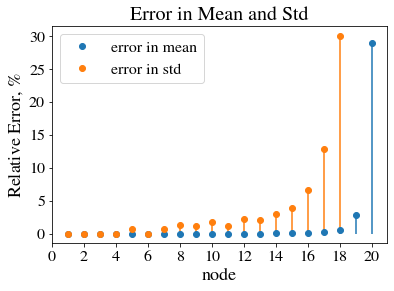

In [17]:
# create a figure
fig_1 = plt.figure()
# array with numbers of nodes passed
nodes_passed = np.arange(1,number_of_nodes+1,1)

# display errors in mean
p1 = plt.plot(nodes_passed,errors_mean,'o', label='error in mean')
c1 = p1[0].get_color()
for node,point in zip(nodes_passed,errors_mean):
    plt.vlines(node,0,point,c1)
    
# display errors in std
# number of nodes in which to display the error in std 
display_nodes_std = 18
p2 = plt.plot(nodes_passed[:display_nodes_std],errors_std[:display_nodes_std],'o', label='error in std')
c2 = p2[0].get_color()
for node,point in zip(nodes_passed[:display_nodes_std],errors_std):
    plt.vlines(node,0,point,c2)
    
# add title, legend, etc.    
plt.title('Error in Mean and Std', fontsize = 20)
plt.legend(fontsize=16)
plt.ylabel("Relative Error, $\%$", fontsize = 18)
plt.xlabel('node', fontsize = 18)
plt.yticks(fontsize=16)
plt.xticks(np.arange(0,number_of_nodes+2,2),fontsize=16);

# fig_1.savefig('lncs_error_in_mean_and_std.pdf', format='pdf', bbox_inches="tight")

The reason for high error in last nodes is that the topology of all Gaussian combs used in this test is fixed. Thus, it becomes nonoptimal for the later nodes. Consider two examples below.

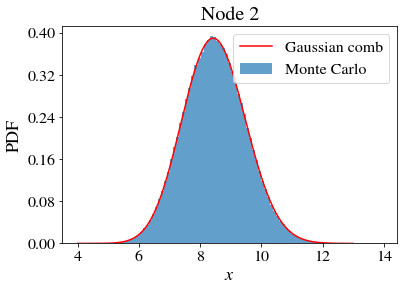

In [18]:
node = 2

fig_2 = plt.figure(figsize=(6,4))

xdata_final = np.arange(4,13,0.01)
# unpack the comb
weights,locs = convols[node-1]

# show a histogram from MC
n, bins, patches = plt.hist(nodes_simulation[node-1], 100, density=True, alpha=0.7, label='Monte Carlo')
# plot a PDF resulting from the RBF algorithm
plt.plot(xdata_final,gauss_comb(xdata_final, weights, locs, shape), 'r-',label='Gaussian comb')

plt.title('Node %s' % node, fontsize = 20)
plt.legend(fontsize = 16)
plt.ylabel("PDF", fontsize = 18)
plt.xlabel('$x$', fontsize = 18)
plt.yticks(np.linspace(0,0.4,6),fontsize=16)
plt.xticks(fontsize=16);

# fig_2.savefig('lncs_node_%s.pdf' % node, format='pdf', bbox_inches="tight")

At node 2, the Gaussian comb fits the distribution perfectly, resulting in no error in mean and std.

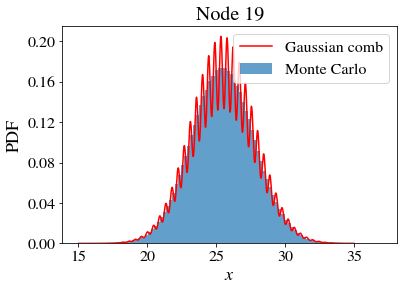

In [19]:
node = 19

fig_3 = plt.figure(figsize=(6,4))

xdata_final = np.arange(15,35,0.01)
# unpack the comb
weights,locs = convols[node-1]

# show a histogram from MC
n, bins, patches = plt.hist(nodes_simulation[node-1], 100, density=True, alpha=0.7, label='Monte Carlo')
# plot a PDF resulting from the RBF algorithm
plt.plot(xdata_final,gauss_comb(xdata_final, weights, locs, shape), 'r-',label='Gaussian comb')

plt.title('Node %s' % node, fontsize = 20)
plt.legend(fontsize=16)
plt.ylabel("PDF", fontsize = 18)
plt.xlabel('$x$', fontsize = 18)
plt.yticks(np.arange(0,0.24,0.04),fontsize=16)
plt.xticks(fontsize=16);

# fig_3.savefig('lncs_node_%s.pdf' % node, format='pdf', bbox_inches="tight")

At node 19, the comb sprawls as the bandwidth $\Delta y$ becomes large and the topology of the Gaussian comb is no longer optimal.